In [1]:
import pandas as pd
import nltk
import string
import warnings
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
filename=r'..\DatasetEnglish.csv'
datasetEng=pd.read_csv(filename)
datasetEng=datasetEng.drop(['index'], axis=1)
datasetEng.shape

(4959, 64)

In [40]:
datasetEng.shape
dataE = datasetEng.copy()

In [41]:
# Let's combine the title and the details of the talk.
dataE['details'] = dataE['talk_title'] + ' ' + dataE['transcript']


In [42]:
# Removing the unnecessary information
dataE = dataE[['speakers_name', 'details','talk_id']]
dataE.dropna(inplace = True)
dataE.head()

,speakers_name,details,talk_id
0,Aakash Odedra,"A dance in a hurricane of paper, wind and ligh...",2147
1,Aala El-Khani,What it's like to be a parent in a war zone W...,2683
2,Aarathi Krishnan,5 ethical principles for digitizing humanitari...,91525
3,Aaron Bastani,A socialist perspective on the pursuit of happ...,101504
4,"Aaron Duffy, Lake Buckley and Jack Foster","""Illusions for a better society"" Narrator: We...",14610


In [8]:
dataE.shape

(4958, 2)

In [43]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    
    imp_words = []

# Storing the important words
    for word in str(text).split():
        word = word.lower()
        
        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


In [44]:
dataE['details'] = dataE['details'].apply(lambda text: remove_stopwords(text))
dataE.head()

,speakers_name,details,talk_id
0,Aakash Odedra,"dance hurricane paper, wind light (music) (app...",2147
1,Aala El-Khani,"like parent war zone worldwide, 1.5 billion pe...",2683
2,Aarathi Krishnan,5 ethical principles digitizing humanitarian a...,91525
3,Aaron Bastani,socialist perspective pursuit happiness allow ...,101504
4,"Aaron Duffy, Lake Buckley and Jack Foster","""illusions better society"" narrator: today spe...",14610


In [45]:
punctuations_list = string.punctuation

def cleaning_punctuations(text):
    signal = str.maketrans('', '', punctuations_list)
    return text.translate(signal)
 
dataE['details'] = dataE['details'].apply(lambda x: cleaning_punctuations(x))
dataE.head()

,speakers_name,details,talk_id
0,Aakash Odedra,dance hurricane paper wind light music applause,2147
1,Aala El-Khani,like parent war zone worldwide 15 billion peop...,2683
2,Aarathi Krishnan,5 ethical principles digitizing humanitarian a...,91525
3,Aaron Bastani,socialist perspective pursuit happiness allow ...,101504
4,"Aaron Duffy, Lake Buckley and Jack Foster",illusions better society narrator today specif...,14610


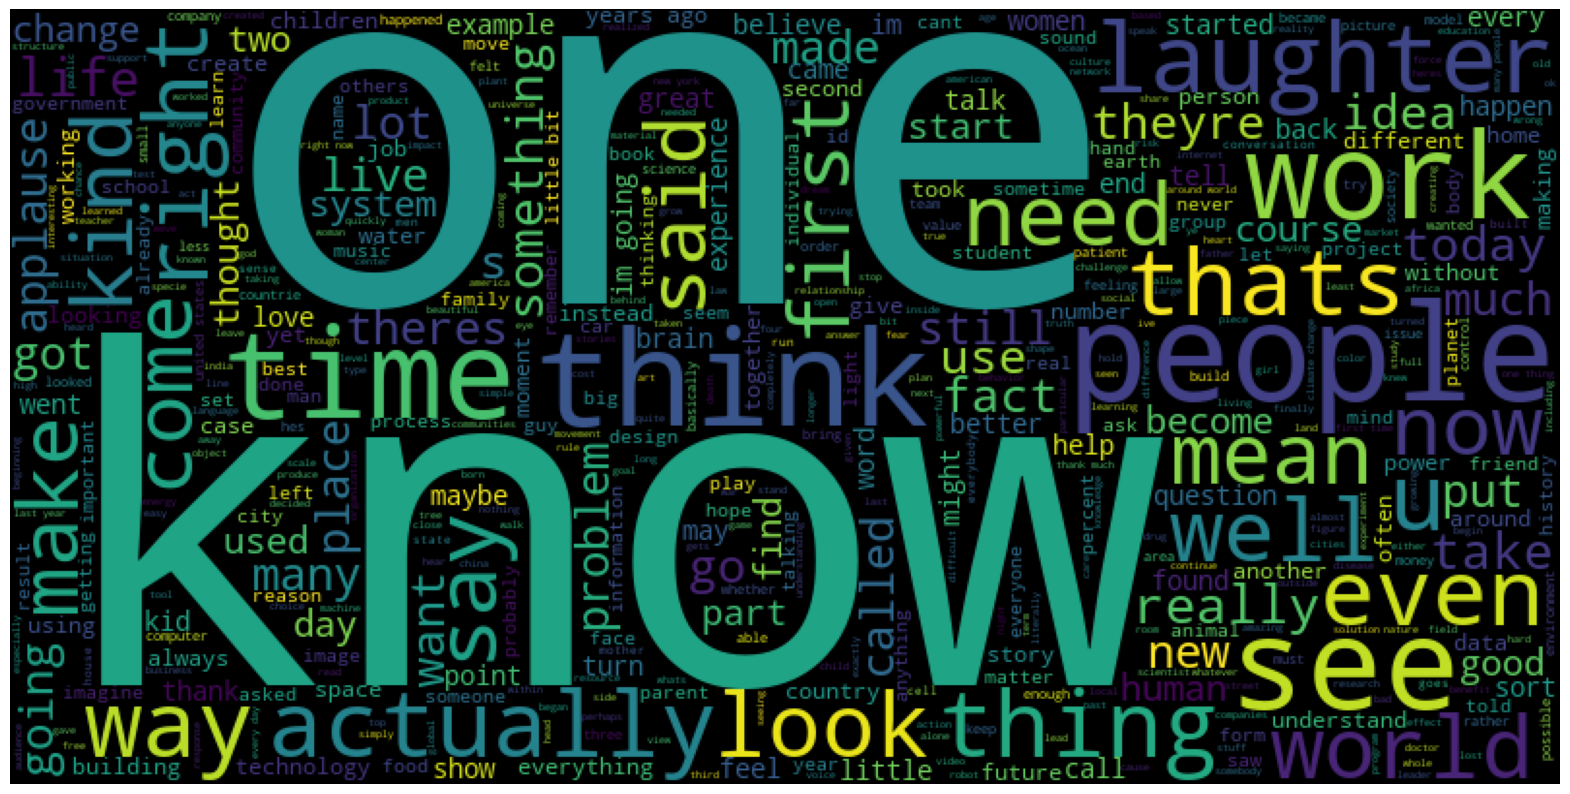

In [14]:
details_corpus = " ".join(dataE['details'])
 
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000, 
               width=800,
               height=400).generate(details_corpus)
plt.axis('off')
plt.imshow(wc)
plt.show()

In [21]:
%%capture
vectorizer = TfidfVectorizer(analyzer = 'word')
vectorizer.fit(dataE['details'])

In [46]:
vectorizer = TfidfVectorizer(analyzer = 'word')

tfidf_matrix = vectorizer.fit_transform(dataE['details'])


def get_similarities(talk_content, data=dataE):

    talk_vector = vectorizer.transform([talk_content])

    sim = []
    pea = []
    for idx, row in data.iterrows():
        details = row['details']

        talk_vector2 = vectorizer.transform([details])

        cos_sim = cosine_similarity(talk_vector, talk_vector2)[0][0]

        pea_sim = pearsonr(talk_vector.toarray().squeeze(), talk_vector2.toarray().squeeze())[0]

        sim.append(cos_sim)
        pea.append(pea_sim)

    return sim, pea

def recommend_talks(talk_content, data=dataE):
    data['cos_sim'], data['pea_sim'] = get_similarities(talk_content)
    data.sort_values(by=['cos_sim', 'pea_sim'], ascending=[False, False], inplace=True)

    display(data[['speakers_name', 'details']].head())

In [47]:
talk_content = 'A dance in a hurricane of paper, wind and light'
recommend_talks(talk_content)

,speakers_name,details
0,Aakash Odedra,dance hurricane paper wind light music applause
842,Chinyanta Kabaso,dazzling diversity african dance 14 moves rhy...
711,Camille A. Brown,visual history social dance 25 moves bop bop t...
4080,Ryan Heffington,dance unleash inner joy thank you cheers appl...
222,Alyssa-Amor Gibbons,design climateresilient buildings child growin...


In [20]:
recommend_talks(datasetEng['talk_title'].iloc[0])

,speakers_name,details
0,Aakash Odedra,dance hurricane paper wind light music applause
842,Chinyanta Kabaso,dazzling diversity african dance 14 moves rhy...
711,Camille A. Brown,visual history social dance 25 moves bop bop t...
4080,Ryan Heffington,dance unleash inner joy thank you cheers appl...
222,Alyssa-Amor Gibbons,design climateresilient buildings child growin...


In [21]:
datasetEng.iloc[0][['related_talk_1_slug', 'related_talk_2_slug','related_talk_3_slug','related_talk_4_slug',
                    'related_talk_5_slug']].values

array(['pilobolus_a_dance_of_symbiosis',
       'quixotic_fusion_dancing_with_light',
       'kenichi_ebina_my_magic_moves',
       'aakash_odedra_a_dance_in_a_hurricane_of_paper_wind_and_light',
       'joey_alexander_an_11_year_old_prodigy_performs_old_school_jazz'],
      dtype=object)